In [1]:
import os
import tempfile
from copy import deepcopy
from pathlib import Path

import numpy as np
import torch
from PIL import Image
from torch import optim
from torch.nn import functional as F
from torchvision import transforms, utils
from tqdm import tqdm
from util import *


from e4e_projection import projection as e4e_projection
from model import Discriminator, Generator

/home/aiteam/miniconda3/envs/final/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.makedirs('inversion_codes', exist_ok=True)
os.makedirs('style_images', exist_ok=True)
os.makedirs('style_images_aligned', exist_ok=True)
os.makedirs('models', exist_ok=True)

In [4]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat models/dlibshape_predictor_68_face_landmarks.dat

# Download pretrained weight
!gdown --id 1o6ijA3PkcewZvwJJ73dJ0fxhndn0nnh7 -O /home/aiteam/tykim/JoJoGAN/models/e4e_ffhq_encode.pt

!gdown --id 1Yr7KuD959btpmcKGAUsbAk5rPjX2MytK -O /home/aiteam/tykim/JoJoGAN/models/stylegan2-ffhq-config-f.pt

--2022-05-24 02:43:47--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.1’

shape_predictor_68_ 100%[===================>]  61.07M  8.47MB/s    in 9.4s    

2022-05-24 02:43:57 (6.47 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2.1’ saved [64040097/64040097]



In [3]:
# Set up
device = 'cuda'
torch.backends.cudnn.benchmark = True
latent_dim = 512
seed = 3000
torch.manual_seed(seed)
%matplotlib inline
plt.rcParams['figure.dpi'] = 150


# Set pretrained Models
# 원래 FFHQ에 학습된 generator
original_generator = Generator(1024, latent_dim, 8, 2).to(device)
ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
original_generator.load_state_dict(ckpt["g_ema"], strict=False)

# Fine tuned되어질 Generator
generator = deepcopy(original_generator)



discriminator = Discriminator(1024, 2).eval().to(device)
ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
discriminator.load_state_dict(ckpt["d"], strict=False)



# 10000개의 w를 만들고 평균을 낸다. [1,512]
mean_latent = original_generator.mean_latent(10000)

In [4]:
# PIL을 Tensor로 바꿀 transform
transform = transforms.Compose(
    [
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt
Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt
Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt
Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt


/home/aiteam/miniconda3/envs/final/lib/python3.9/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


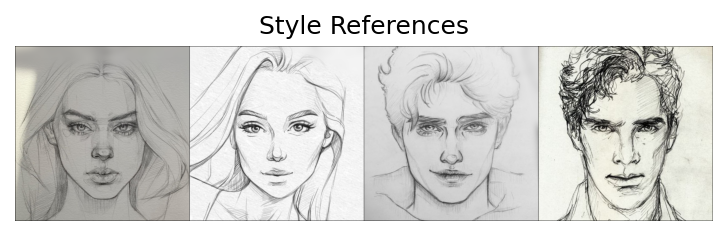

In [5]:
# Style Reference Inversion
names = ['sketch.jpeg', 'sketch2.jpeg', 'sketch3.jpeg', 'sketch4.jpeg']
# names =  ['image_03894.jpg', 'sketch3.jpeg', 'sketch4.jpeg']
targets = [] # style ref의 tensor 형태
latents = [] # style ref의 w 형태

for name in names:
  # Style Image를 얻고 이를 Crop and align
  style_path = os.path.join('style_images', name)
  assert os.path.exists(style_path), f"{style_path} does not exist!"
  # Alignment를 하고 png로 저장한다.
  name = strip_path_extension(name)
  style_aligned_path = os.path.join('style_images_aligned', f'{name}.png')
  # 이미 align한게 있다면 그냥 불러온다. 
  if not os.path.exists(style_aligned_path):
    style_aligned = align_face(style_path)
    style_aligned.save(style_aligned_path)
  else:
    style_aligned = Image.open(style_aligned_path).convert('RGB')

  # GAN Invert를 해서 w를 찾아낸다.
  style_code_path = os.path.join('inversion_codes', f'{name}.pt')
  if not os.path.exists(style_code_path):
    latent = e4e_projection(style_aligned, style_code_path, device)
  else:
    latent = torch.load(style_code_path)['latent']

  # PIL -> Tensor
  # 원래는 여러개가 들어감 [N, 18, 512] 이렇게 되야 하는데 
  targets.append(transform(style_aligned).to(device))
  latents.append(latent.to(device))

targets = torch.stack(targets, 0)
latents = torch.stack(latents, 0)  #torch.Size([1, 18, 512])
# latents[:, [1,2]].shape : torch.Size([1, 2, 512])
# latents.shape : [4, 18, 512] 원래는 4가지 style ref를 사용하기 때문에 

target_im = utils.make_grid(targets, normalize=True, range=(-1, 1))
display_image(target_im, title='Style References')

Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt


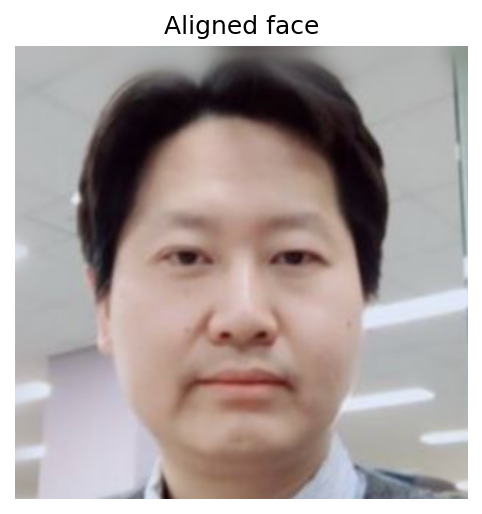

In [6]:
# 변환하고자 하는 소스 이미지 Inversion
# filename = 'son_3.jpg'
filename = 'park.jpg'
filepath = f'test_input/{filename}'
name = strip_path_extension(filepath)+'.pt'
aligned_face = align_face(filepath)
my_w = e4e_projection(aligned_face, name, device).unsqueeze(0)
display_image(aligned_face, title='Aligned face')

In [14]:
# Training

# mixing 정도를 조절
alpha = 1.0
preserve_color = False
num_iter = 1500
log_interval = 50




discriminator = Discriminator(1024, 2).eval().to(device)
ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
discriminator.load_state_dict(ckpt["d"], strict=False)


generator = Generator(1024, latent_dim, 8, 2).to(device)
ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
generator.load_state_dict(ckpt["g_ema"], strict=False)


g_optim = optim.Adam(generator.parameters(), lr=2e-3, betas=(0, 0.99))
# mixing할 부분 디폴트 : [7,8,...18]
id_swap = list(range(7, generator.n_latent))


for idx in tqdm(range(num_iter)):
  # Mapping Net [Num of StyleRefs, 512] -> [Num of StyleRefs, 1, 512] -> [Num of StyleRefs, 18, 512]
  # Style refernece별로 18개의 w가 같은 값을 지닌다. 
  mean_w = generator.get_latent(torch.randn([latents.size(0), latent_dim]).to(device)).unsqueeze(1).repeat(1, generator.n_latent, 1)

  mean_w = torch.randn([3, 18, 512], device='cuda')
  # lnt = generator.get_latent(torch.randn([1, 512]).to(device))
  # [1, 1, 512] -> [1, 18, 512]
  # mean_w = lnt.unsqueeze(1).repeat(1, generator.n_latent, 1)
  in_latent = latents.clone()
  # print(in_latent.shape)
  # in_latent = torch.randn([3, 18, 512], device='cuda')
  # 원래 [N, 18, 512]인데 18개의 레이어에서 어느 부분을 mixing시킬지

  print(mean_w.shape)
  print(latents.shape)
  print((alpha * latents[:, id_swap]).shape)
  print(((1-alpha)*mean_w[:, id_swap]).shape)
  print(in_latent[:, id_swap].shape)

  
  in_latent[:, id_swap] = alpha * latents[:, id_swap] + (1-alpha)*mean_w[:, id_swap]
  
  img =  generator(in_latent, input_is_latent=True)

  print(targets.shape)
  targets = torch.randn([3, 3, 1024, 1024], device='cuda')
  with torch.no_grad():
    real_feat = discriminator(targets)
  fake_feat = discriminator(img)
  
  loss = sum([F.l1_loss(a, b) for a, b in zip(fake_feat, real_feat)])/len(fake_feat)
  print(idx, loss)
  print(loss.is_leaf)
  print()
  loss.backward()
  g_optim.step()
  g_optim.zero_grad()

  0%|          | 0/1500 [00:00<?, ?it/s]

torch.Size([3, 18, 512])
torch.Size([4, 18, 512])
torch.Size([4, 11, 512])
torch.Size([3, 11, 512])
torch.Size([4, 11, 512])


RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0

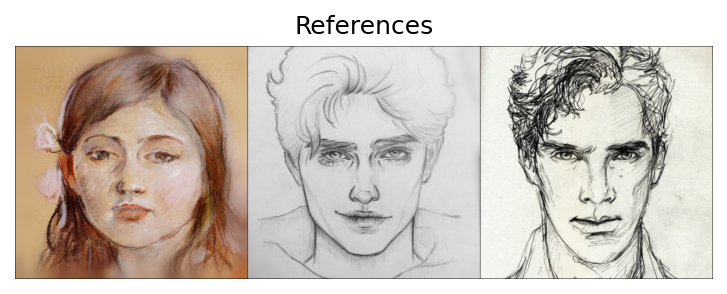

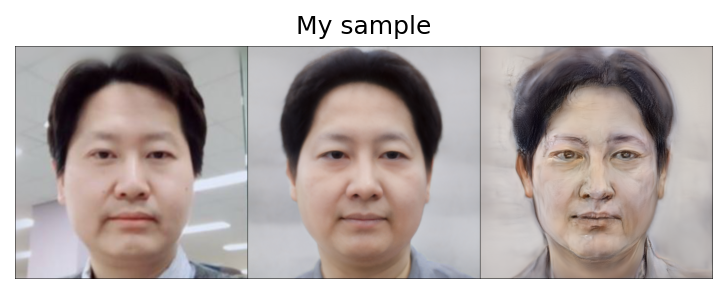

In [7]:
# Inference
with torch.no_grad():
  original_my_sample = original_generator(my_w, input_is_latent=True)
  my_sample = generator(my_w, input_is_latent=True)

# display reference images
style_images = []
for name in names:
    style_path = f'style_images_aligned/{strip_path_extension(name)}.png'
    style_image = transform(Image.open(style_path))
    style_images.append(style_image)


face = transform(aligned_face).to(device).unsqueeze(0)
style_images = torch.stack(style_images, 0).to(device)
display_image(utils.make_grid(style_images, normalize=True, range=(-1, 1)), title='References')

my_output = torch.cat([face, original_my_sample,  my_sample], 0)
display_image(utils.make_grid(my_output, normalize=True, range=(-1, 1)), title='My sample')

In [ ]:
# 변환하고자 하는 소스 이미지 Inversion
# filename = 'son_3.jpg'
filename = 'park.jpg'
filepath = f'test_input/{filename}'
name = strip_path_extension(filepath)+'.pt'
aligned_face = align_face(filepath)
my_w = e4e_projection(aligned_face, name, device).unsqueeze(0)
display_image(aligned_face, title='Aligned face')